In [300]:
# import custom_functions as cf
import pandas as pd
import numpy as np

import matplotlib, matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set(style="whitegrid", color_codes=True)

import math

import itertools as it

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [305]:
def list_files(files):
    """Accepts a list and returns a dictionary of each item in list with a numbered index (key) starting at 1"""

    dir_list = {0:'Exit'}
    file_count = 0
    for file in files:
        file_count +=1
        dir_list[file_count] = file  # assign a number to each item in the list starting with 1 
    return dir_list  # returns the dictionary of items in the list

def print_dict(dict_items):
    """Prints the (key : value) pairing in a dictionary"""

    for key, value in dict_items.items():
        print(key, ":", value)    

def check_dict(dict_to_check, choice):
    """Checks if the input choice is a key in the provided dictionary
        and returns 'valid' if true, 'invalid' if false"""

    if choice in dict_to_check:
        return "valid"
    else:
        return "invalid"

def error_message(invalid_choice):
    print(f"Your input of '{invalid_choice}' is not a valid choice. Try again!")

def validate_int(user_input):
    """Checks if user input is an int or can be converted to an int. If true returns 'valid', if false returns 'invalid'"""

    try:
        int(float(user_input))
        return "valid"
    except ValueError:
        return "invalid"

def target_test_keys(keys): 
    """Accepts a list of lists and returns a list of the first value from each list"""
    
    spec_keys = []
    for i in range(len(keys)):
        spec_keys.append(keys[i][0])
    return spec_keys

def get_target_columns(col_list, spec_keys):
    target_columns = []
    for i in range(len(col_list)):
        if col_list[i] in spec_keys:
            target_columns.append(col_list[i])
    return target_columns

def create_spec_dict(spec_arr):
    new_dict = {}
    new_list = []
    for i in range(len(spec_arr)):
        new_list = [spec_arr[i][1],spec_arr[i][2]]
        new_dict[spec_arr[i][0]] = new_list
    return new_dict

def combine_limits(targ_col,prod_spec_dict):  # This is making an assumption that the lower limits are listed before upper limits in specifications file
    prod_ll = []
    prod_ul = []
    prod_ll_dict = {}
    prod_ul_dict = {}
    for i in range(len(targ_col)):
        key = targ_col[i]
        prod_ll.append(prod_spec_dict[key][0])
        prod_ul.append(prod_spec_dict[key][1])
        
    prod_ll_dict['lower_limits'] = prod_ll  # create dict of lower limits
    prod_ul_dict['upper_limits'] = prod_ul  # create dict of upper limits
    return {**prod_ll_dict, **prod_ul_dict}  # return dict of both dictionaries

def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

### Display file options to user

In [83]:
product_options = sorted(list(('BR0010P850','YL0010C229')))
user_options = list_files(product_options)  # returned dict of files in directory
print_dict(user_options)

0 : Exit
1 : BR0010P850
2 : YL0010C229


### Allow user to choose a product displayed above

In [84]:
user_choice = input('Enter the number next to the file to open. (0 to exit): ')
validate_choice = validate_int(user_choice) # confirm user input is an int or can be converted to an int 
if validate_choice == 'valid':
    user_choice = int(float(user_choice))
    validate_choice = check_dict(user_options, user_choice) # check to see if user input is a key in the dictionary
while validate_choice == 'invalid':
    error_message(user_choice)
    user_choice = input('Enter the number next to the file to open. (0 to exit): ')
    validate_choice = validate_int(user_choice)
    if validate_choice == 'valid':
        user_choice = int(float(user_choice))
        validate_choice = check_dict(user_options, user_choice) # check to see if user input is a key in the dictionary

selected_product = user_options[user_choice]
if selected_product == 'Exit':
    print(f'No product selected')
else:
    print(f'You selected {selected_product}')

You selected BR0010P850


### Set file paths

In [85]:
if selected_product == 'Exit':
    print('No product was selected from the cell above. Please select a product in the cell above to continue.')
else:
    path = 'data/'
    file_ext = ".xlsx"
    prod_ingredient_file = path + selected_product + "_ingredients" + file_ext
    prod_color_results = path + selected_product + "_color_results" + file_ext
    approved_ingredients = path + "approved_ingredients" + file_ext  # all products are in this file
    formulas = path + "formulas" + file_ext  # all products are in this file
    specifications = path + "specifications" + file_ext  # all product specs are in this file

### Read files into pandas dataframe

In [86]:
ingredient_df = pd.read_excel(prod_ingredient_file)  # ingriendients used for each batch of selected product
color_results_df= pd.read_excel(prod_color_results)  # color results for each batch of selected product
approv_ingred_df = pd.read_excel(approved_ingredients).sort_values(by=['Material','rm_code'])
approv_ingred_df = approv_ingred_df[approv_ingred_df['Material']== selected_product + '-RMIX']  # filter df by selected product
formula_df = pd.read_excel(formulas).sort_values(by=['Material','Ingredient'])
formula_df = formula_df[formula_df['Material']== selected_product + '-RMIX']  # filter df by selected product
product_specs_df = pd.read_excel(specifications)
product_specs_df = product_specs_df[product_specs_df['product'] == selected_product].set_index('product')

### Investigate ingredient df for null values and data types

In [87]:
print(ingredient_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date Issued                 66 non-null     datetime64[ns]
 1   Material                    228 non-null    object        
 2   Order                       66 non-null     float64       
 3   RMIX Batch                  228 non-null    int64         
 4   Antimony Oxide              228 non-null    object        
 5   Manganic Oxide              228 non-null    object        
 6   Titanium Dioxide - Anatase  228 non-null    object        
 7   Kiln                        66 non-null     float64       
 8   Hearth                      0 non-null      float64       
 9   Cycle                       0 non-null      float64       
 10  Temp                        0 non-null      float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(4)
memo

### Modify ingredient df as needed

In [88]:
ingredient_df_mod =  ingredient_df.drop(columns=['Date Issued', 'Order',
       'Kiln', 'Hearth', 'Cycle', 'Temp'])
ingredient_df_mod['RMIX Batch'] = ingredient_df_mod['RMIX Batch'].astype(str)  # RMIX Batch looks like an int but should be treated like a string

### Investigate color results df for null values and data types

In [89]:
print(color_results_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RMIX Batch  220 non-null    int64  
 1   Fin Batch   220 non-null    int64  
 2   Equip       220 non-null    object 
 3   MDL         220 non-null    float64
 4   MDA         220 non-null    float64
 5   MDB         220 non-null    float64
 6   TDL         220 non-null    float64
 7   TDA         220 non-null    float64
 8   TDB         220 non-null    float64
 9   STR         220 non-null    int64  
dtypes: float64(6), int64(3), object(1)
memory usage: 17.3+ KB
None


### Modify color results df as needed

In [90]:
# color_results_df_mod =  color_results_df.drop(columns=[''])
color_results_df_mod = color_results_df
color_results_df_mod[['RMIX Batch','Fin Batch']] = color_results_df_mod[['RMIX Batch','Fin Batch']].astype(str)  # RMIX Batch & Fin Batch should be treated like a string

### Merge ingredient df and color df

In [173]:
df = ingredient_df_mod.merge(color_results_df_mod,how='left',left_on='RMIX Batch',right_on='RMIX Batch')

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 0 to 227
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Material                    228 non-null    object 
 1   RMIX Batch                  228 non-null    object 
 2   Antimony Oxide              228 non-null    object 
 3   Manganic Oxide              228 non-null    object 
 4   Titanium Dioxide - Anatase  228 non-null    object 
 5   Fin Batch                   201 non-null    object 
 6   Equip                       201 non-null    object 
 7   MDL                         201 non-null    float64
 8   MDA                         201 non-null    float64
 9   MDB                         201 non-null    float64
 10  TDL                         201 non-null    float64
 11  TDA                         201 non-null    float64
 12  TDB                         201 non-null    float64
 13  STR                         201 non

<AxesSubplot:>

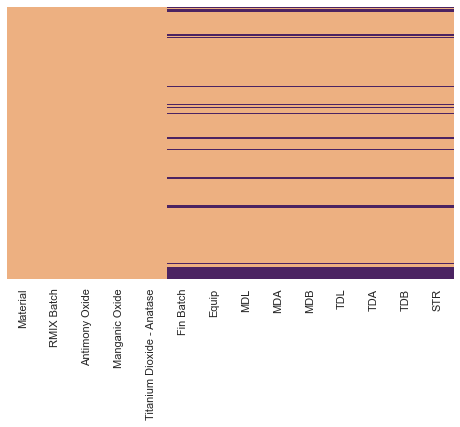

In [182]:
plt.figure(figsize=(8,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap="flare")

### Only interested in rows that have both ingredients and color values

In [184]:
df = df.dropna()

In [185]:
df.info()
df.to_excel('data/output.xlsx',index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 1 to 217
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Material                    201 non-null    object 
 1   RMIX Batch                  201 non-null    object 
 2   Antimony Oxide              201 non-null    object 
 3   Manganic Oxide              201 non-null    object 
 4   Titanium Dioxide - Anatase  201 non-null    object 
 5   Fin Batch                   201 non-null    object 
 6   Equip                       201 non-null    object 
 7   MDL                         201 non-null    float64
 8   MDA                         201 non-null    float64
 9   MDB                         201 non-null    float64
 10  TDL                         201 non-null    float64
 11  TDA                         201 non-null    float64
 12  TDB                         201 non-null    float64
 13  STR                         201 non

In [95]:
df

,Material,RMIX Batch,Antimony Oxide,Manganic Oxide,Titanium Dioxide - Anatase,Fin Batch,Equip,MDL,MDA,MDB,TDL,TDA,TDB,STR
1,BR0010P850-RMIX,23633,RM0615,RM4620,RM6729,23799,MX003,-1.0,-0.4,-0.9,-0.7,-0.4,-1.0,104.0
4,BR0010P850-RMIX,54216,RM0615,RM4620,RM6718,54250,MX003,0.6,0.1,0.0,-0.2,0.2,0.3,102.0
5,BR0010P850-RMIX,54715,RM0615,RM4620,RM6718,54729,MX003,-1.4,-0.4,-0.7,-0.4,-0.4,-1.0,102.0
6,BR0010P850-RMIX,54716,RM0615,RM4620,RM6718,54730,MX003,-0.1,-0.2,-0.7,-0.2,-0.1,-0.6,101.0
7,BR0010P850-RMIX,54717,RM0615,RM4620,RM6729,54731,MX003,-0.4,-0.1,-0.3,-0.6,0.0,-0.2,104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,BR0010P850-RMIX,40693,RM0615,RM4621,RM6713,40705,MX003,0.4,-0.1,-0.2,0.5,-0.2,-0.1,97.0
213,BR0010P850-RMIX,40694,RM0615,RM4621,RM6713,40706,MX003,0.1,-0.2,-0.2,0.6,-0.3,-0.6,95.0
214,BR0010P850-RMIX,41775,RM0615,RM4620,RM6713,41792,MX003,-0.3,0.0,-0.1,-0.1,-0.1,-0.2,100.0
216,BR0010P850-RMIX,41779,RM0615,RM4620,RM6713,41794,MX003,0.1,0.0,0.1,-0.1,0.0,0.2,101.0


In [96]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MDL,201.0,-0.044279,0.661725,-2.5,-0.5,-0.1,0.4,3.3
MDA,201.0,-0.084080,0.202102,-1.6,-0.2,-0.1,0.0,0.4
MDB,201.0,-0.197512,0.411149,-1.6,-0.4,-0.2,0.0,2.2
TDL,201.0,0.189055,0.602644,-0.7,-0.2,0.1,0.4,4.3
TDA,201.0,-0.114925,0.217431,-2.0,-0.2,-0.1,0.0,0.3
TDB,201.0,-0.179104,0.412142,-1.9,-0.4,-0.2,0.0,1.2
STR,201.0,98.611940,3.839096,73.0,97.0,99.0,101.0,105.0


### Arrange product specifications to compare against color results

In [97]:
prod_specs_arr = product_specs_df.values  # create numpy array from product specifications df
prod_target_keys = target_test_keys(prod_specs_arr)  # creates a list of product test keys that are in specifications file
target_columns = get_target_columns(df.columns, prod_target_keys)  # creates a list of column name values from the selected file that match values in prod_target_keys list
prod_spec_dict = create_spec_dict(prod_specs_arr)  # creates a dict of prod test keys {key = test key: value = [lower limit value, upper limit value]}
prod_limits_dict = combine_limits(target_columns,prod_spec_dict) # create dict of all product limits {key = upper_limits or lower_limits: value = [all test key limits]}


### Compare product color results versus product specifications

In [98]:
test_values = df[target_columns].to_numpy(dtype=float)  # numpy array of color results that have an associated product specification
lower_limits = np.array(prod_limits_dict['lower_limits'])
upper_limits = np.array(prod_limits_dict['upper_limits'])
is_below_ll = (np.less(test_values,lower_limits))  # array displays true if test value below lower spec limit
is_above_ul = (np.greater(test_values,upper_limits))  # array displays true if test value above upper spec limit
combined_arr = np.add(is_below_ll, is_above_ul)  # adds the two boolean arrays 
# create dataframe of the reverse boolean numpy array (using ~)
combined_df_in_spec = ~pd.DataFrame(data=combined_arr[0:,0:],
                        index=(df['Fin Batch'].values),  #  assuming "Lot" is a column name in selected product file
                        columns=target_columns)

print(combined_arr)

[[False False False ... False  True False]
 [False False False ... False False False]
 [False False False ... False  True False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [99]:
combined_df_in_spec['is_in_spec'] = combined_df_in_spec.prod(1)  # create column in df to show if all test results for a batch are within all specifications
batch_in_spec_df = combined_df_in_spec['is_in_spec']
target_df = df.merge(batch_in_spec_df, how='left', left_on='Fin Batch', right_index=True)

In [100]:
product_ingredients = formula_df['Ingredient'].tolist()
target_df['Raws Combined'] = target_df[product_ingredients].agg(','.join,axis=1)
print(target_df.head())

          Material RMIX Batch Antimony Oxide Manganic Oxide  \
1  BR0010P850-RMIX      23633         RM0615         RM4620   
4  BR0010P850-RMIX      54216         RM0615         RM4620   
5  BR0010P850-RMIX      54715         RM0615         RM4620   
6  BR0010P850-RMIX      54716         RM0615         RM4620   
7  BR0010P850-RMIX      54717         RM0615         RM4620   

  Titanium Dioxide - Anatase Fin Batch  Equip  MDL  MDA  MDB  TDL  TDA  TDB  \
1                     RM6729     23799  MX003 -1.0 -0.4 -0.9 -0.7 -0.4 -1.0   
4                     RM6718     54250  MX003  0.6  0.1  0.0 -0.2  0.2  0.3   
5                     RM6718     54729  MX003 -1.4 -0.4 -0.7 -0.4 -0.4 -1.0   
6                     RM6718     54730  MX003 -0.1 -0.2 -0.7 -0.2 -0.1 -0.6   
7                     RM6729     54731  MX003 -0.4 -0.1 -0.3 -0.6  0.0 -0.2   

     STR  is_in_spec         Raws Combined  
1  104.0           0  RM0615,RM4620,RM6729  
4  102.0           1  RM0615,RM4620,RM6718  
5  102.0   

In [101]:
total_df_rows = combined_df_in_spec.shape[0]
total_in_spec_rows = combined_df_in_spec['is_in_spec'].sum()
print(total_df_rows)
print(total_in_spec_rows)

201
158


In [102]:
target_df.to_excel('data/output.xlsx',index=False)

In [149]:
target_df['Raws Combined'].value_counts()

RM0615,RM4620,RM6729    39
RM0615,RM4615,RM6729    35
RM0615,RM4615,RM6713    33
RM0615,RM4620,RM6707    17
RM0615,RM4620,RM6713    15
RM0615,RM4626,RM6729    14
RM0615,RM4626,RM6707    11
RM0615,RM4615,RM6707     7
RM0615,RM4621,RM6729     7
RM0615,RM4621,RM6713     7
RM0615,RM4623,RM6713     5
RM0615,RM4620,RM6718     3
RM0615,RM4626,RM6713     2
RM0615,RM4621,RM6707     2
RM0615,RM4620,RM6714     2
RM0615,RM4623,RM6729     1
RM0614,RM4620,RM6713     1
Name: Raws Combined, dtype: int64

In [150]:
target_df['Raws Combined'].value_counts(normalize=True).round(2)

RM0615,RM4620,RM6729    0.19
RM0615,RM4615,RM6729    0.17
RM0615,RM4615,RM6713    0.16
RM0615,RM4620,RM6707    0.08
RM0615,RM4620,RM6713    0.07
RM0615,RM4626,RM6729    0.07
RM0615,RM4626,RM6707    0.05
RM0615,RM4615,RM6707    0.03
RM0615,RM4621,RM6729    0.03
RM0615,RM4621,RM6713    0.03
RM0615,RM4623,RM6713    0.02
RM0615,RM4620,RM6718    0.01
RM0615,RM4626,RM6713    0.01
RM0615,RM4621,RM6707    0.01
RM0615,RM4620,RM6714    0.01
RM0615,RM4623,RM6729    0.00
RM0614,RM4620,RM6713    0.00
Name: Raws Combined, dtype: float64

In [265]:
test_df1 = target_df[['Raws Combined','is_in_spec']].groupby('Raws Combined').agg(['count', 'sum']).reset_index()
# test_df1.set_axis('Raws Combined')
test_df1['tot_count'] = test_df1['is_in_spec']['count']
test_df1['num_in_spec'] = test_df1['is_in_spec']['sum']
test_df1['per_in_spec'] = round((test_df1['num_in_spec']/test_df1['tot_count']*100),1)
#test_df1.drop('is_in_spec',axis=1,inplace=True)

test_df2 = test_df1[['Raws Combined','tot_count','num_in_spec','per_in_spec']].copy().sort_values(by='tot_count',ascending=False)
#test_df1.sort_values(by='tot_count',ascending=False)
#new_df= pd.DataFrame(test_df1['Raws Combined'],test_df1['tot_count'],test_df1'num_in_spec'])
# new_df[['A','B']] = test_df1[[test_df1['Raws Combined'],test_df1['tot_count']]]

# test_df1 = test_df.set_index('Raws Combined')
# f, ax = plt.subplots(figsize=(6, 15))
# total_count = 
#plt.figure(figsize=(15,5))

#print(target_df['Raws Combined'].size())


# test_df1.sort_values(by=test_df1['is_in_spec']['count'],ascending=False)
test_df2



,Raws Combined,tot_count,num_in_spec,per_in_spec
,,,,
8,"RM0615,RM4620,RM6729",39,34,87.2
3,"RM0615,RM4615,RM6729",35,28,80.0
2,"RM0615,RM4615,RM6713",33,28,84.8
4,"RM0615,RM4620,RM6707",17,14,82.4
5,"RM0615,RM4620,RM6713",15,13,86.7
16,"RM0615,RM4626,RM6729",14,13,92.9
14,"RM0615,RM4626,RM6707",11,7,63.6
1,"RM0615,RM4615,RM6707",7,3,42.9
10,"RM0615,RM4621,RM6713",7,5,71.4


### What raw combinations are being used the most?

In [335]:
test_df1 = target_df[['Raws Combined','is_in_spec']].groupby('Raws Combined').agg(['count', 'sum']).reset_index()
test_df1['tot_count'] = test_df1['is_in_spec']['count']
test_df1['num_in_spec'] = test_df1['is_in_spec']['sum']
test_df1['per_in_spec'] = round((test_df1['num_in_spec']/test_df1['tot_count']*100),1)
test_df2 = test_df1[['Raws Combined','tot_count','num_in_spec','per_in_spec']].copy().sort_values(by='tot_count',ascending=False)


In [336]:
test_df2['tot_count'].max()

39

[Text(0, 0, '34'),
 Text(0, 0, '28'),
 Text(0, 0, '28'),
 Text(0, 0, '14'),
 Text(0, 0, '13'),
 Text(0, 0, '13'),
 Text(0, 0, '7'),
 Text(0, 0, '3'),
 Text(0, 0, '5'),
 Text(0, 0, '4'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '0'),
 Text(0, 0, '0')]

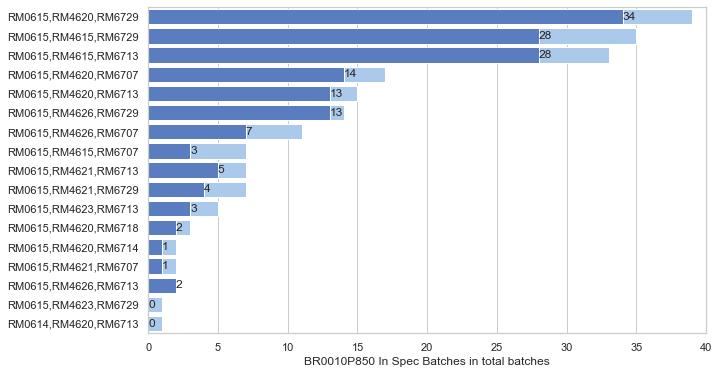

In [360]:
f, ax = plt.subplots(figsize=(10, 6))
sns.set_color_codes("pastel")
sns.barplot(y='Raws Combined',x='tot_count', data=test_df2,color='b')

sns.set_color_codes("muted")
sns.barplot(y='Raws Combined',x='num_in_spec', data=test_df2, color='b')

x_axis_scale = int(round_up(test_df2['tot_count'].max(),-1))
ax.set(xlim=(0, x_axis_scale), ylabel="",
       xlabel= selected_product + " In Spec Batches in total batches")
ax.bar_label(ax.containers[1])

[Text(0, 0, '34'),
 Text(0, 0, '28'),
 Text(0, 0, '28'),
 Text(0, 0, '14'),
 Text(0, 0, '13'),
 Text(0, 0, '13'),
 Text(0, 0, '7'),
 Text(0, 0, '3'),
 Text(0, 0, '5'),
 Text(0, 0, '4'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '0'),
 Text(0, 0, '0')]

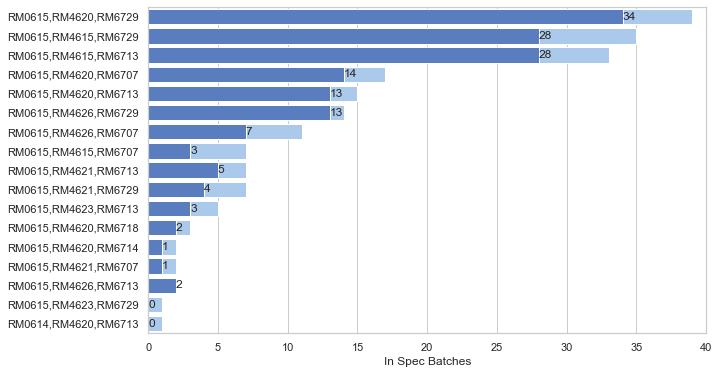

In [358]:

# total_count = sns.load_dataset(test_df['count'])
f, ax = plt.subplots(figsize=(10, 6))
# ax = plt.subplots(figsize=(6, 8))

sns.set_color_codes("pastel")
sns.barplot(y='Raws Combined',x='tot_count', data=test_df2,color='b')

sns.set_color_codes("muted")
sns.barplot(y='Raws Combined',x='num_in_spec', data=test_df2, color='b')

#ax.legend(ncol=2, loc="lower right", frameon=True)
x_axis_scale = int(round_up(test_df2['tot_count'].max(),-1))
ax.set(xlim=(0, x_axis_scale), ylabel="",
       xlabel="In Spec Batches")
ax.bar_label(ax.containers[1])
# for index, row in test_df2.iterrows():
#      ax.text(row.Raws Combined, row.per_in_spec, row.tot_count,
#              color='white', ha='center')
#sns.despine(left=True, bottom=True)

# sns.barplot(x="alcohol", y="abbrev", data=crashes,
            # label="Alcohol-involved", color="b")

# sns.countplot(y='Raws Combined',data=target_df,order=target_df['Raws Combined'].value_counts().index).set_title(selected_product + ' Raw Combinations')
# f, ax = plt.subplots(figsize=(6, 15))
# sns.set_color_codes("pastel")
# sns.barplot(x="total", y="abbrev", data=total_count,
#             label="Total", color="b")



Text(0.5, 1.0, 'BR0010P850 Raw Combinations')

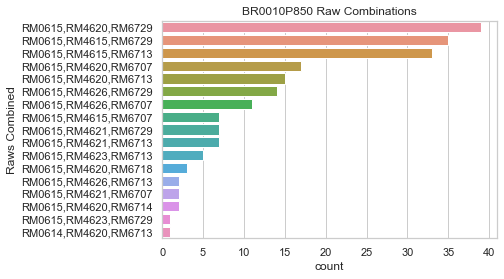

In [170]:
sns.countplot(y='Raws Combined',data=target_df,order=target_df['Raws Combined'].value_counts().index).set_title(selected_product + ' Raw Combinations')
# Would be nice to work a date range in there too

In [361]:
target_df

,Material,RMIX Batch,Antimony Oxide,Manganic Oxide,Titanium Dioxide - Anatase,Fin Batch,Equip,MDL,MDA,MDB,TDL,TDA,TDB,STR,is_in_spec,Raws Combined
1,BR0010P850-RMIX,23633,RM0615,RM4620,RM6729,23799,MX003,-1.0,-0.4,-0.9,-0.7,-0.4,-1.0,104.0,0,"RM0615,RM4620,RM6729"
4,BR0010P850-RMIX,54216,RM0615,RM4620,RM6718,54250,MX003,0.6,0.1,0.0,-0.2,0.2,0.3,102.0,1,"RM0615,RM4620,RM6718"
5,BR0010P850-RMIX,54715,RM0615,RM4620,RM6718,54729,MX003,-1.4,-0.4,-0.7,-0.4,-0.4,-1.0,102.0,0,"RM0615,RM4620,RM6718"
6,BR0010P850-RMIX,54716,RM0615,RM4620,RM6718,54730,MX003,-0.1,-0.2,-0.7,-0.2,-0.1,-0.6,101.0,1,"RM0615,RM4620,RM6718"
7,BR0010P850-RMIX,54717,RM0615,RM4620,RM6729,54731,MX003,-0.4,-0.1,-0.3,-0.6,0.0,-0.2,104.0,1,"RM0615,RM4620,RM6729"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,BR0010P850-RMIX,40693,RM0615,RM4621,RM6713,40705,MX003,0.4,-0.1,-0.2,0.5,-0.2,-0.1,97.0,1,"RM0615,RM4621,RM6713"
213,BR0010P850-RMIX,40694,RM0615,RM4621,RM6713,40706,MX003,0.1,-0.2,-0.2,0.6,-0.3,-0.6,95.0,1,"RM0615,RM4621,RM6713"
214,BR0010P850-RMIX,41775,RM0615,RM4620,RM6713,41792,MX003,-0.3,0.0,-0.1,-0.1,-0.1,-0.2,100.0,1,"RM0615,RM4620,RM6713"
216,BR0010P850-RMIX,41779,RM0615,RM4620,RM6713,41794,MX003,0.1,0.0,0.1,-0.1,0.0,0.2,101.0,1,"RM0615,RM4620,RM6713"


In [423]:
# f, ax = plt.subplots(figsize=(10, 6))
def create_boxplot(df,test_key,spec_limits,prod_name):

    low_spec = spec_limits[0]
    upp_spec = spec_limits[1]

    plt.figure(figsize=(10,6))
    box_plot = sns.boxplot(x=test_key, y='Raws Combined',data=df)
    sns.stripplot(x=test_key, y='Raws Combined',data=df,color='black',alpha=0.35,jitter=1,size=4)
    plt.axvline(low_spec,color='red',label="LSL")
    plt.axvline(upp_spec,color='red',label="USL")
    plt.title(prod_name + " " + test_key)
    plt.xlabel("")
    plt.ylabel("")

    # medians = df.groupby(['Raws Combined'])[test_key].median()
    # vertical_offset = df[test_key].median() * 0.05 # offset from median for display

    # for xtick in box_plot.get_xticks():
    #     box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
    #         horizontalalignment='center',size='x-small',color='w',weight='semibold')

In [410]:
medians = target_df.groupby(['Raws Combined'])[test_key].median()
medians

Raws Combined
RM0614,RM4620,RM6713    1.00
RM0615,RM4615,RM6707   -0.80
RM0615,RM4615,RM6713   -0.20
RM0615,RM4615,RM6729   -0.40
RM0615,RM4620,RM6707   -0.50
RM0615,RM4620,RM6713   -0.10
RM0615,RM4620,RM6714   -0.05
RM0615,RM4620,RM6718   -0.10
RM0615,RM4620,RM6729    0.10
RM0615,RM4621,RM6707    0.35
RM0615,RM4621,RM6713    0.10
RM0615,RM4621,RM6729    0.00
RM0615,RM4623,RM6713    0.60
RM0615,RM4623,RM6729    1.20
RM0615,RM4626,RM6707    0.20
RM0615,RM4626,RM6713    0.00
RM0615,RM4626,RM6729    0.30
Name: MDL, dtype: float64

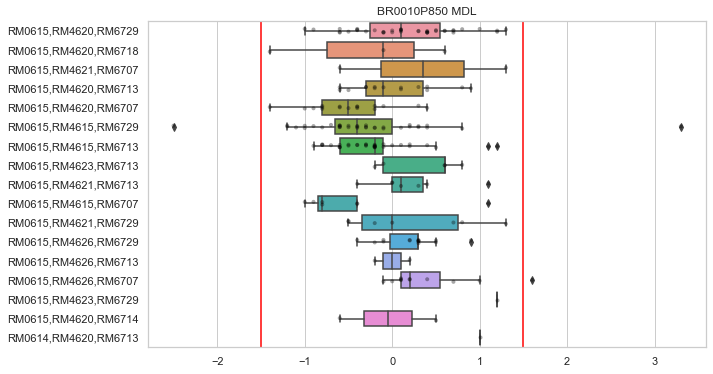

In [424]:
test_key = 'MDL'
test_key_limits = prod_spec_dict[test_key]
create_boxplot(target_df,test_key,test_key_limits,selected_product)

In [203]:
test_df = target_df.groupby('Raws Combined').size().reset_index(name='count').sort_values(by='count',ascending=False)
test_df



,Raws Combined,count
8,"RM0615,RM4620,RM6729",39
3,"RM0615,RM4615,RM6729",35
2,"RM0615,RM4615,RM6713",33
4,"RM0615,RM4620,RM6707",17
5,"RM0615,RM4620,RM6713",15
16,"RM0615,RM4626,RM6729",14
14,"RM0615,RM4626,RM6707",11
1,"RM0615,RM4615,RM6707",7
10,"RM0615,RM4621,RM6713",7
11,"RM0615,RM4621,RM6729",7


In [103]:
target_df.groupby(target_df['Raws Combined']).sum()



,MDL,MDA,MDB,TDL,TDA,TDB,STR,is_in_spec
Raws Combined,,,,,,,,
"RM0614,RM4620,RM6713",1.0,0.3,1.0,1.3,0.0,0.8,92.0,0
"RM0615,RM4615,RM6707",-3.2,-1.8,-2.6,2.6,-2.3,-3.2,681.0,3
"RM0615,RM4615,RM6713",-7.0,-3.0,-6.9,6.1,-4.4,-8.4,3254.0,28
"RM0615,RM4615,RM6729",-11.1,-5.8,-12.0,5.4,-6.6,-12.6,3456.0,28
"RM0615,RM4620,RM6707",-8.4,-5.2,-7.9,2.3,-5.1,-7.7,1679.0,14
"RM0615,RM4620,RM6713",0.2,-0.3,-0.2,2.2,-0.6,-0.3,1485.0,13
"RM0615,RM4620,RM6714",-0.1,-0.3,0.1,1.7,-0.4,0.3,189.0,1
"RM0615,RM4620,RM6718",-0.9,-0.5,-1.4,-0.8,-0.3,-1.3,305.0,2
"RM0615,RM4620,RM6729",6.6,1.2,-2.4,-3.6,1.9,1.3,3926.0,34


In [104]:
print(len(set(target_df['Raws Combined'])))
print(set(target_df['Raws Combined']))

17
{'RM0615,RM4626,RM6707', 'RM0615,RM4626,RM6729', 'RM0615,RM4620,RM6713', 'RM0615,RM4626,RM6713', 'RM0615,RM4620,RM6714', 'RM0615,RM4615,RM6713', 'RM0615,RM4623,RM6729', 'RM0615,RM4623,RM6713', 'RM0614,RM4620,RM6713', 'RM0615,RM4621,RM6713', 'RM0615,RM4621,RM6729', 'RM0615,RM4620,RM6718', 'RM0615,RM4615,RM6729', 'RM0615,RM4620,RM6729', 'RM0615,RM4620,RM6707', 'RM0615,RM4615,RM6707', 'RM0615,RM4621,RM6707'}


In [105]:

product_ingredients = formula_df['Ingredient'].tolist()
test_dict = {}
test_list = []
for i in range(len(product_ingredients)):
   ingred = product_ingredients[i]
   df_ingred = approv_ingred_df.loc[approv_ingred_df['ingredient_name'] == ingred]
   ingred_list = df_ingred['rm_code'].to_list()
   test_dict[ingred] = ingred_list
   test_list.append(test_dict[ingred])
   print(test_list)


for key, value in test_dict.items():
   print(key,value)
#    approv_ingred_df.iloc

# prod = os.path.splitext(selected_file)[0]  # separate filename from extension 
# df_prod_specs = df_all_specs.iloc[lambda x: x.index == prod]  # filter specifications by product name from the selected file

[['RM0614', 'RM0615']]
[['RM0614', 'RM0615'], ['RM4615', 'RM4620', 'RM4621', 'RM4623', 'RM4626']]
[['RM0614', 'RM0615'], ['RM4615', 'RM4620', 'RM4621', 'RM4623', 'RM4626'], ['RM6707', 'RM6713', 'RM6714', 'RM6718', 'RM6729']]
Antimony Oxide ['RM0614', 'RM0615']
Manganic Oxide ['RM4615', 'RM4620', 'RM4621', 'RM4623', 'RM4626']
Titanium Dioxide - Anatase ['RM6707', 'RM6713', 'RM6714', 'RM6718', 'RM6729']


In [113]:
all_combinations = list(it.product(*test_list))
print(all_combinations[0])

# aggregate batch ingredients and count ratio of grade 1?


('RM0614', 'RM4615', 'RM6707')


In [107]:
# approv_ingred_df = pd.read_excel('data/approved_ingredients.xlsx').set_index('ingredient_name')

product_ingredients = formula_df['Ingredient'].tolist()
print(product_ingredients)

listA = ['a','b','c','d','e']
listB = ['c','d','e']
listC = ['f','g','h']


listA = (list(it.combinations(['Antimony Oxide', 'Manganic Oxide', 'Titanium Dioxide - Anatase'],3)))
listB = (list(it.combinations(['Antimony Oxide', 'Antimony Oxide', 'Titanium Dioxide - Anatase'],3)))
listC = (list(it.combinations(['Antimony Oxide', 'Manganic Oxide', 'Manganic Oxide'],3)))

print()

# xy = (zip(listA,listB))
# print(list(xy))
# # new_list = 

# convert lists to sets and test equality before adding to a unique list
# if set(product_ingredients) == for each comb in list(it.combinations(approved_list,3))

['Antimony Oxide', 'Manganic Oxide', 'Titanium Dioxide - Anatase']



In [108]:
print(ingredient_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date Issued                 66 non-null     datetime64[ns]
 1   Material                    228 non-null    object        
 2   Order                       66 non-null     float64       
 3   RMIX Batch                  228 non-null    int64         
 4   Antimony Oxide              228 non-null    object        
 5   Manganic Oxide              228 non-null    object        
 6   Titanium Dioxide - Anatase  228 non-null    object        
 7   Kiln                        66 non-null     float64       
 8   Hearth                      0 non-null      float64       
 9   Cycle                       0 non-null      float64       
 10  Temp                        0 non-null      float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(4)
memo

In [109]:
# ingredient_df[['RMIX Batch', 'Kiln', 'Hearth','Cycle']] = ingredient_df[['RMIX Batch', 'Kiln', 'Hearth','Cycle']].astype(str)

In [110]:
ing_df_wk['RMIX Batch'] = ing_df_wk['RMIX Batch'].astype(str)

NameError: name 'ing_df_wk' is not defined

In [ ]:
ing_df_wk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Material                    230 non-null    object
 1   RMIX Batch                  230 non-null    object
 2   Antimony Oxide              230 non-null    object
 3   Manganic Oxide              230 non-null    object
 4   Titanium Dioxide - Anatase  230 non-null    object
dtypes: object(5)
memory usage: 9.1+ KB


In [ ]:
# print(color_results_df.info())

In [ ]:
print(color_results_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RMIX Batch  221 non-null    int64  
 1   Fin Batch   221 non-null    int64  
 2   Equip       221 non-null    object 
 3   MDL         221 non-null    float64
 4   MDA         221 non-null    float64
 5   MDB         221 non-null    float64
 6   TDL         221 non-null    float64
 7   TDA         221 non-null    float64
 8   TDB         221 non-null    float64
 9   STR         221 non-null    int64  
dtypes: float64(6), int64(3), object(1)
memory usage: 17.4+ KB
None


In [ ]:
color_results_df[['RMIX Batch', 'Fin Batch']] = color_results_df[['RMIX Batch', 'Fin Batch']].astype(str)

In [ ]:
color_df_wk = color_results_df

In [ ]:
color_df_wk

,RMIX Batch,Fin Batch,Equip,MDL,MDA,MDB,TDL,TDA,TDB,STR
0,23633,23799,MX003,-1.0,-0.4,-0.9,-0.7,-0.4,-1.0,104
1,35324,35816,MX003,-0.2,-0.2,-0.5,-0.3,-0.4,-0.8,102
2,42908,53780,MX007,0.0,-0.1,-0.2,0.2,-0.1,-0.2,98
3,42909,53781,MX003,0.2,-0.2,-0.4,-0.1,-0.1,-0.3,100
4,42910,53782,MX003,0.4,0.0,-0.2,0.2,0.0,0.0,98
...,...,...,...,...,...,...,...,...,...,...
216,40693,40705,MX003,0.4,-0.1,-0.2,0.5,-0.2,-0.1,97
217,40694,40706,MX003,0.1,-0.2,-0.2,0.6,-0.3,-0.6,95
218,41775,41792,MX003,-0.3,0.0,-0.1,-0.1,-0.1,-0.2,100
219,41779,41794,MX003,0.1,0.0,0.1,-0.1,0.0,0.2,101


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231 entries, 0 to 230
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Material                    231 non-null    object 
 1   RMIX Batch                  231 non-null    object 
 2   Antimony Oxide              231 non-null    object 
 3   Manganic Oxide              231 non-null    object 
 4   Titanium Dioxide - Anatase  231 non-null    object 
 5   Fin Batch                   203 non-null    object 
 6   Equip                       203 non-null    object 
 7   MDL                         203 non-null    float64
 8   MDA                         203 non-null    float64
 9   MDB                         203 non-null    float64
 10  TDL                         203 non-null    float64
 11  TDA                         203 non-null    float64
 12  TDB                         203 non-null    float64
 13  STR                         203 non

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203 entries, 1 to 220
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Material                    203 non-null    object 
 1   RMIX Batch                  203 non-null    object 
 2   Antimony Oxide              203 non-null    object 
 3   Manganic Oxide              203 non-null    object 
 4   Titanium Dioxide - Anatase  203 non-null    object 
 5   Fin Batch                   203 non-null    object 
 6   Equip                       203 non-null    object 
 7   MDL                         203 non-null    float64
 8   MDA                         203 non-null    float64
 9   MDB                         203 non-null    float64
 10  TDL                         203 non-null    float64
 11  TDA                         203 non-null    float64
 12  TDB                         203 non-null    float64
 13  STR                         203 non

In [ ]:
df['Material'].dtype == 'object'

True

In [ ]:
for column in df.columns:
    print(f'{column} (' + str(df.loc[df[column]==''].count().iloc[0]) + ' empty strings)')

Material (0 empty strings)
RMIX Batch (0 empty strings)
Antimony Oxide (0 empty strings)
Manganic Oxide (0 empty strings)
Titanium Dioxide - Anatase (0 empty strings)
Fin Batch (0 empty strings)
Equip (0 empty strings)
MDL (0 empty strings)
MDA (0 empty strings)
MDB (0 empty strings)
TDL (0 empty strings)
TDA (0 empty strings)
TDB (0 empty strings)
STR (0 empty strings)


In [ ]:
print(approv_ingred_df.head())

                        Material rm_code
ingredient_name                         
Antimony Oxide   BR0010P850-RMIX  RM0615
Antimony Oxide   BR0010P850-RMIX  RM0614
Manganic Oxide   BR0010P850-RMIX  RM4620
Manganic Oxide   BR0010P850-RMIX  RM4621
Manganic Oxide   BR0010P850-RMIX  RM4615


In [ ]:
for i in range(len(product_ingredients)):
    print(f'{i +1} {product_ingredients[i]}')


1 Antimony Oxide
2 Manganic Oxide
3 Titanium Dioxide - Anatase


In [ ]:
print(approv_ingred_df)

           Material rm_code             ingredient_name
1   BR0010P850-RMIX  RM0614              Antimony Oxide
0   BR0010P850-RMIX  RM0615              Antimony Oxide
4   BR0010P850-RMIX  RM4615              Manganic Oxide
2   BR0010P850-RMIX  RM4620              Manganic Oxide
3   BR0010P850-RMIX  RM4621              Manganic Oxide
5   BR0010P850-RMIX  RM4623              Manganic Oxide
6   BR0010P850-RMIX  RM4626              Manganic Oxide
8   BR0010P850-RMIX  RM6707  Titanium Dioxide - Anatase
10  BR0010P850-RMIX  RM6713  Titanium Dioxide - Anatase
11  BR0010P850-RMIX  RM6714  Titanium Dioxide - Anatase
9   BR0010P850-RMIX  RM6718  Titanium Dioxide - Anatase
7   BR0010P850-RMIX  RM6729  Titanium Dioxide - Anatase


In [ ]:
approv_ingred_df[approv_ingred_df['ingredient_name'] == 'Titanium Dioxide - Anatase']
# approv_ingred_df[(approv_ingred_df['ingredient_name'] == 'Titanium Dioxide - Anatase') & (approv_ingred_df['Material'] == 'BR0010P850-RMIX')]

,Material,rm_code,ingredient_name
8,BR0010P850-RMIX,RM6707,Titanium Dioxide - Anatase
10,BR0010P850-RMIX,RM6713,Titanium Dioxide - Anatase
11,BR0010P850-RMIX,RM6714,Titanium Dioxide - Anatase
9,BR0010P850-RMIX,RM6718,Titanium Dioxide - Anatase
7,BR0010P850-RMIX,RM6729,Titanium Dioxide - Anatase


In [ ]:
approv_ingred_df.query('ingredient_name == "Titanium Dioxide - Anatase"')

,Material,rm_code,ingredient_name
8,BR0010P850-RMIX,RM6707,Titanium Dioxide - Anatase
10,BR0010P850-RMIX,RM6713,Titanium Dioxide - Anatase
11,BR0010P850-RMIX,RM6714,Titanium Dioxide - Anatase
9,BR0010P850-RMIX,RM6718,Titanium Dioxide - Anatase
7,BR0010P850-RMIX,RM6729,Titanium Dioxide - Anatase


In [ ]:
approv_ingred_df.loc[approv_ingred_df['ingredient_name'] == 'Titanium Dioxide - Anatase']

,Material,rm_code,ingredient_name
8,BR0010P850-RMIX,RM6707,Titanium Dioxide - Anatase
10,BR0010P850-RMIX,RM6713,Titanium Dioxide - Anatase
11,BR0010P850-RMIX,RM6714,Titanium Dioxide - Anatase
9,BR0010P850-RMIX,RM6718,Titanium Dioxide - Anatase
7,BR0010P850-RMIX,RM6729,Titanium Dioxide - Anatase


In [ ]:

test_dict = {}
for i in range(len(product_ingredients)):
   ingred = product_ingredients[i]
   ingred_num = f'ingred_{i+1}'
   df_ingred = approv_ingred_df.loc[approv_ingred_df['ingredient_name'] == ingred]

   print(df_ingred)

#    approv_ingred_df.iloc

# prod = os.path.splitext(selected_file)[0]  # separate filename from extension 
# df_prod_specs = df_all_specs.iloc[lambda x: x.index == prod]  # filter specifications by product name from the selected file

          Material rm_code ingredient_name
1  BR0010P850-RMIX  RM0614  Antimony Oxide
0  BR0010P850-RMIX  RM0615  Antimony Oxide
          Material rm_code ingredient_name
4  BR0010P850-RMIX  RM4615  Manganic Oxide
2  BR0010P850-RMIX  RM4620  Manganic Oxide
3  BR0010P850-RMIX  RM4621  Manganic Oxide
5  BR0010P850-RMIX  RM4623  Manganic Oxide
6  BR0010P850-RMIX  RM4626  Manganic Oxide
           Material rm_code             ingredient_name
8   BR0010P850-RMIX  RM6707  Titanium Dioxide - Anatase
10  BR0010P850-RMIX  RM6713  Titanium Dioxide - Anatase
11  BR0010P850-RMIX  RM6714  Titanium Dioxide - Anatase
9   BR0010P850-RMIX  RM6718  Titanium Dioxide - Anatase
7   BR0010P850-RMIX  RM6729  Titanium Dioxide - Anatase
